In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
import pandas

2023-11-22 11:08:57.474176: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-22 11:08:57.498016: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
train_file = "../train.tsv"
test_file = "../test.tsv"

train_data = pandas.read_csv(train_file, delimiter='\t').to_numpy()
train_data2 = np.empty((train_data.shape[0], train_data.shape[1]-2))
train_data2[:, 0:] = train_data[:, 2:]
train_data2[:,0:1] = train_data2[:,0:1] * 0   #季節を0～0に正規化
train_data2[:,2:3] = train_data2[:, 2:3] * 62.3 / 12 #月を0～62.3に正規化
train_data2[:,3:4] = train_data2[:, 3:4] * 0.2 / 23 #時間を0～0.2に正規化
train_data2[:,5:6] = train_data2[:,5:6] * 5 / 6.0   #曜日を0～5に正規化
train_data2[:,7:8] = train_data2[:,7:8] * 2 / 4.0   #天気を0～2に正規化
train_data2 = train_data2#.astype(np.float32)
rnd = np.random.default_rng()
rnd.shuffle(train_data2,axis=0)

test_data = pandas.read_csv(test_file, delimiter='\t').to_numpy()
test_data2 = np.empty((test_data.shape[0], test_data.shape[1]-2))
test_data2[:, 0:] = test_data[:, 2:]
test_data2[:,0:1] = test_data2[:,0:1] * 0   #季節を0～0に正規化
test_data2[:,2:3] = test_data2[:, 2:3] / 12 #月を0～2に正規化
test_data2[:,3:4] = test_data2[:, 3:4] / 23 #時間を0～2に正規化
test_data2[:,5:6] = test_data2[:,5:6] / 6.0   #曜日を0～1に正規化
test_data2[:,7:8] = test_data2[:,7:8] / 4.0   #天気を0～1に正規化
test_data2 = test_data2.astype(np.float32)

display(train_data2)
display(test_data2)

x = train_data2[:, 12:]
x = x.reshape(x.shape[0], 1)
#print(x)
y = train_data2[:, :12]
y = y.reshape(y.shape[0], y.shape[1], 1)
#print(y)
test_y = test_data2.reshape(test_data2.shape[0], test_data2.shape[1], 1)
z = test_data2[:, :12]
z = z.reshape(z.shape[0], z.shape[1], 1)

array([[0.00000000e+00, 0.00000000e+00, 4.15333333e+01, ...,
        5.10000000e-01, 1.64200000e-01, 4.37000000e+02],
       [0.00000000e+00, 0.00000000e+00, 4.15333333e+01, ...,
        7.90000000e-01, 2.23900000e-01, 8.60000000e+01],
       [0.00000000e+00, 0.00000000e+00, 3.63416667e+01, ...,
        5.60000000e-01, 2.23900000e-01, 2.80000000e+01],
       ...,
       [0.00000000e+00, 0.00000000e+00, 1.03833333e+01, ...,
        3.70000000e-01, 3.28400000e-01, 6.00000000e+01],
       [0.00000000e+00, 0.00000000e+00, 2.59583333e+01, ...,
        5.90000000e-01, 1.34300000e-01, 4.06000000e+02],
       [0.00000000e+00, 0.00000000e+00, 5.19166667e+00, ...,
        4.00000000e-01, 5.22400000e-01, 4.90000000e+01]])

array([[0.        , 1.        , 0.08333334, ..., 0.3788    , 0.66      ,
        0.        ],
       [0.        , 1.        , 0.08333334, ..., 0.3485    , 0.66      ,
        0.1343    ],
       [0.        , 1.        , 0.08333334, ..., 0.3485    , 0.76      ,
        0.        ],
       ...,
       [0.        , 1.        , 1.        , ..., 0.2576    , 0.6       ,
        0.1642    ],
       [0.        , 1.        , 1.        , ..., 0.2727    , 0.56      ,
        0.1343    ],
       [0.        , 1.        , 1.        , ..., 0.2727    , 0.65      ,
        0.1343    ]], dtype=float32)

In [3]:
length_of_sequence = y.shape[1]
#print(length_of_sequence)
in_out_neurons = 1 #入出力ノード数
n_hidden = 1024  #隠れ層 -> 数が多い程，学習モデルの複雑さが増加 #増やした

model = Sequential()
model.add(LSTM(n_hidden, input_shape=(length_of_sequence, in_out_neurons), return_sequences=False))
model.add(Dense(in_out_neurons))
model.add(Activation("linear"))
optimizer = Adam(learning_rate=0.001)
model.compile(loss="mean_squared_error", optimizer=optimizer, metrics=["accuracy"])

2023-11-22 11:08:59.561652: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-22 11:08:59.580078: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-22 11:08:59.580115: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-22 11:08:59.584120: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-22 11:08:59.584160: I tensorflow/compile

In [4]:
y.shape

(8645, 12, 1)

In [5]:
ES = EarlyStopping(mode='auto', patience=32)
model.fit(y, x,
          batch_size=16, #デフォは32
          epochs=512, #512epochで学習
          validation_split=0.2, #学習データの5%をvalidationに用いる
          callbacks=[ES]
          )

Epoch 1/512


2023-11-22 11:09:14.299637: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8905
2023-11-22 11:09:16.471804: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-22 11:09:16.492604: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f6da6a40b70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-22 11:09:16.492647: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2023-11-22 11:09:16.497640: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-22 11:09:16.598259: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifeti

433/433 [==============================] - 9s 7ms/step - loss: 19306.3887 - accuracy: 0.0116 - val_loss: 17543.2383 - val_accuracy: 0.0168
Epoch 2/512
433/433 [==============================] - 2s 6ms/step - loss: 18006.0645 - accuracy: 0.0116 - val_loss: 17560.9102 - val_accuracy: 0.0168
Epoch 3/512
433/433 [==============================] - 2s 6ms/step - loss: 18011.4570 - accuracy: 0.0116 - val_loss: 17541.3711 - val_accuracy: 0.0168
Epoch 4/512
433/433 [==============================] - 2s 6ms/step - loss: 18004.3555 - accuracy: 0.0116 - val_loss: 17563.6699 - val_accuracy: 0.0168
Epoch 5/512
433/433 [==============================] - 2s 6ms/step - loss: 17998.7734 - accuracy: 0.0116 - val_loss: 17535.2129 - val_accuracy: 0.0168
Epoch 6/512
433/433 [==============================] - 2s 6ms/step - loss: 18000.4297 - accuracy: 0.0116 - val_loss: 17525.8262 - val_accuracy: 0.0168
Epoch 7/512
433/433 [==============================] - 2s 6ms/step - loss: 18004.5254 - accuracy: 0.0116 -

In [6]:
predicted = model.predict(y,batch_size=32)
model.evaluate(y,x,batch_size=32)

 81/271 [=======>......................] - ETA: 0s

271/271 [==============================] - 1s 3ms/step - loss: 2442.8052 - accuracy: 0.0106


[2442.80517578125, 0.010641989298164845]

In [7]:
r2 = 1 -  np.sum((predicted - x)**2) / np.sum((x - np.mean(x))**2)
print(r2)

0.8635288876333294


In [8]:
predicted

array([[329.7405  ],
       [ 86.96618 ],
       [ 17.8543  ],
       ...,
       [ 58.96063 ],
       [418.49097 ],
       [ 57.505363]], dtype=float32)

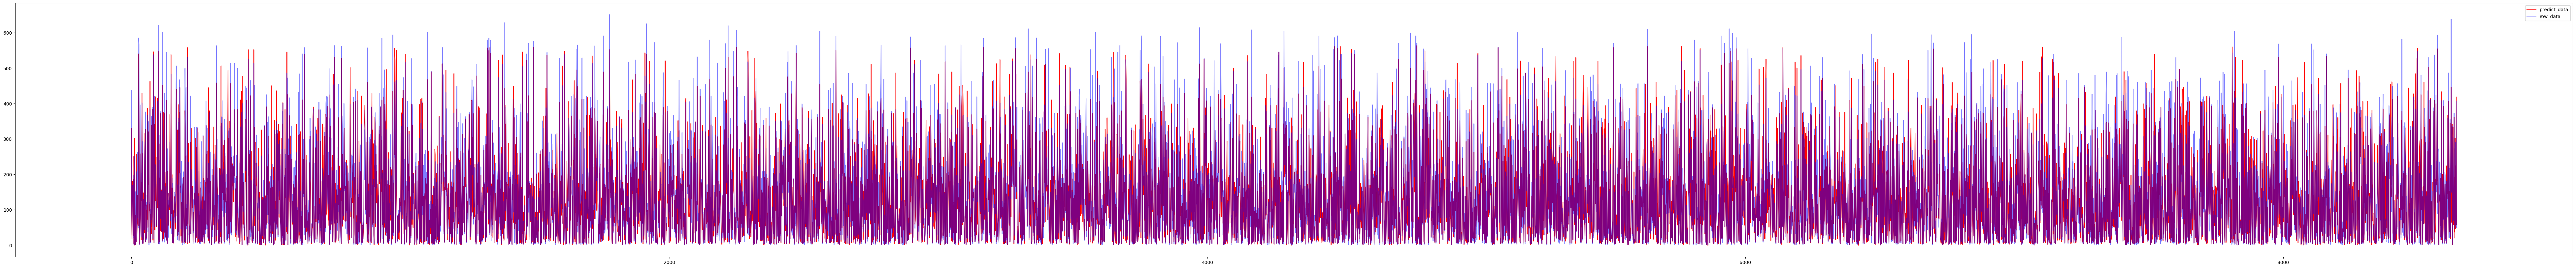

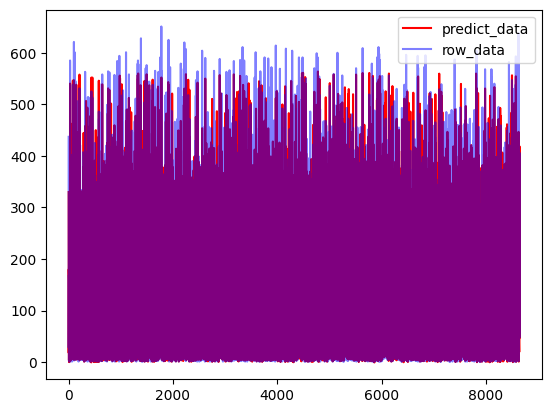

In [9]:
plt.figure(figsize=(100,10))
plt.plot(range(0,len(predicted)),predicted, color="r", label="predict_data")
plt.plot(range(0, len(x)), x, color="b", label="row_data", alpha=0.5)
plt.legend()
plt.show()

plt.figure()
plt.plot(range(0,len(predicted)),predicted, color="r", label="predict_data")
plt.plot(range(0, len(x)), x, color="b", label="row_data", alpha=0.5)
plt.legend()
plt.show()

546/546 [==============================] - 1s 2ms/step
[[14]
 [81]
 [84]
 ...
 [10]
 [10]
 [ 9]]
14
81
84
46
22
16
12
11
11
10
10
10
10
10
10
10
10
10
10
10
10
9
10
10
15
86
59
21
14
13
11
11
10
10
9
9
9
9
9
9
9
9
9
9
9
9
9
51
71
97
61
33
21
16
14
13
12
12
12
11
11
11
11
11
10
10
10
10
10
10
10
68
66
104
68
36
23
18
15
14
13
12
12
11
11
11
11
11
11
11
11
11
11
11
11
119
72
100
73
35
22
16
15
14
13
13
12
12
12
12
12
11
13
11
11
11
10
10
10
77
62
87
72
35
20
17
16
13
12
12
12
12
12
12
12
11
11
11
11
11
11
11
11
23
95
110
73
37
20
16
13
14
13
13
14
15
15
15
15
19
18
14
14
13
13
13
12
13
88
90
58
26
18
15
14
13
12
11
11
11
11
11
10
10
10
10
10
10
10
10
10
30
77
93
63
31
20
16
14
13
12
12
12
12
11
11
11
10
10
10
10
10
10
9
9
63
60
82
28
21
13
12
12
11
11
12
12
12
12
12
11
11
11
11
11
10
10
10
76
54
80
58
30
18
14
13
12
12
12
12
14
15
14
11
11
14
14
13
13
13
13
13
106
61
61
65
33
23
19
14
12
12
12
13
13
11
11
11
11
11
11
13
13
10
10
10
107
72
76
60
36
19
16
15
13
13
12
12
12
12
12
11
11
11
1

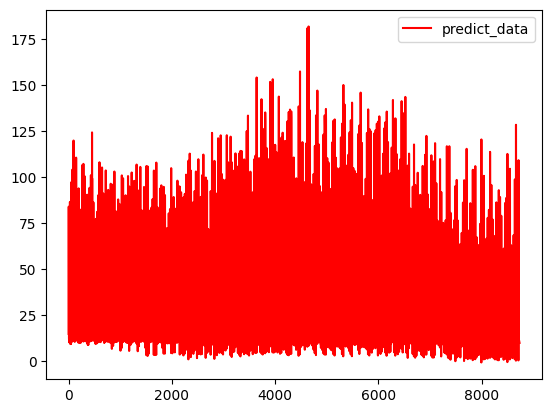

In [10]:
predictedz = model.predict(z,batch_size=16)
zzzzzz = predictedz.astype("int32")
print(zzzzzz)
for i in range(0,8733):
    print(zzzzzz[i,0])
print(np.shape(zzzzzz))

plt.figure()
plt.plot(range(0,len(zzzzzz)),predictedz, color="r", label="predict_data")
plt.legend()
plt.show()